# Running SCENIC+

This tutorial will illustrate how to run the SCENIC+ pipeline via Snakemake based on https://scenicplus.readthedocs.io/en/latest/human_cerebellum.html

Before running this pipeline you should:

- Preprocess the scATAC-seq side of the data using [pycisTopic](https://github.com/aertslab/pycisTopic), [click here](https://pycistopic.readthedocs.io/en/latest/tutorials.html) for a tutorial.
- Preprocess the scRNA-seq side of the data using [Scanpy](https://github.com/scverse/scanpy), [click here](https://scanpy.readthedocs.io/en/stable/tutorials/index.html) for a tutorial.
- Optionally, but highly recommended, generate a cisTarget database using the consensus peaks specific to your dataset, [click here](https://scenicplus.readthedocs.io/en/latest/human_cerebellum_ctx_db.html) for a tutorial.

In case you have human, mouse, or fly data you can also use one of the precomputed cisTarget databases. These can be found on our [resources website](https://resources.aertslab.org/cistarget/databases/).

In [1]:
from typing import Optional, List
from arboreto import core as arboreto_core

import pycisTopic
import scenicplus
scenicplus.__version__
import pandas as pd
import scanpy as sc
import sys
import os
import requests
import pycisTopic
#supress warnings
import warnings  
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pyranges as pr
import requests
import pandas as pd
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
import numpy as np
from pycisTopic.qc import compute_qc_stats
from pycisTopic.iterative_peak_calling import *
import scanpy as sc
from pycisTopic.pseudobulk_peak_calling import peak_calling
_stderr = sys.stderr
null = open(os.devnull,'wb')
import pybiomart as pbm

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-02 21:46:37,160	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
!scenicplus


   ____   ____ _____ _   _ ___ ____      
  / ___| / ___| ____| \ | |_ _/ ___| _ 
  \___ \| |   |  _| |  \| || | |   _|.|_
   ___) | |___| |___| |\  || | |__|_..._|
  |____/ \____|_____|_| \_|___\____||_| 


scenicplus verions: 1.0a1
usage: scenicplus [-h] {init_snakemake,prepare_data,grn_inference} ...

Single-Cell Enhancer-driven gene regulatory Network Inference and Clustering

positional arguments:
  {init_snakemake,prepare_data,grn_inference}

options:
  -h, --help            show this help message and exit


Specify the directory you would like to work in:

In [3]:
os.chdir("/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/")

Below we will use the Snakemake pipeline, which is already included in SCENIC+ to perform the analysis.

You can download the motif databases as follows:

In [4]:
# Download database directly (with wget or curl):
#!wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/screen/mc_v10_clust/region_based/hg38_screen_v10_clust.regions_vs_motifs.rankings.feather

In [5]:
#!wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/screen/mc_v10_clust/region_based/hg38_screen_v10_clust.regions_vs_motifs.scores.feather

In [6]:
#!wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl

Please provide the working, temporary, and output directories below:

In [7]:
import os

In [8]:
work_dir = '/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3'
tmp_dir = "/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/tmp"
out_dir = "/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/outs"

In [9]:
adata = sc.read_h5ad(os.path.join(out_dir, 'scRNA/adata.h5ad'))
adata.obs

,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype,sample_id
AAACAGCCAAATATCC-1-10x_pbmc,2272,0.007582,False,2271,4746.0,369.0,7.774969,NK cells,10,NK_cells,10x_pbmc
AAACAGCCAGGAACTG-1-10x_pbmc,3254,0.022142,False,3253,7760.0,693.0,8.930412,CD14+ Monocytes,5,CD14+_Monocytes,10x_pbmc
AAACAGCCAGGCTTCG-1-10x_pbmc,1798,0.039935,False,1793,3661.0,409.0,11.171811,CD14+ Monocytes,2,CD14+_Monocytes,10x_pbmc
AAACCAACACCTGCTC-1-10x_pbmc,1145,0.023256,False,1142,2159.0,271.0,12.552108,B cells,7,B_cells_1,10x_pbmc
AAACCAACAGATTCAT-1-10x_pbmc,1495,0.013229,False,1494,2909.0,293.0,10.072189,NK cells,4,CD8_T_cells,10x_pbmc
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1-10x_pbmc,1346,0.007582,False,1343,2560.0,432.0,16.875000,B cells,7,B_cells_1,10x_pbmc
TTTGTGGCATTAGCCA-1-10x_pbmc,972,0.026921,False,969,1746.0,191.0,10.939290,CD4 T cells,0,CD4_T_cells,10x_pbmc
TTTGTGGCATTGCGAC-1-10x_pbmc,2330,0.005080,False,2330,4772.0,316.0,6.621961,NK cells,10,NK_cells,10x_pbmc
TTTGTGTTCCGCCTAT-1-10x_pbmc,1057,0.068845,False,1056,1913.0,252.0,13.173027,CD4 T cells,0,CD4_T_cells,10x_pbmc


## Initialize Snakemake

To run Snakemake we first have to initialize the pipeline. This will create a folder named `Snakemake` containing a folder for the `config.yaml` file and a folder containing the actual workflow definition.

In [10]:
!mkdir -p scplus_pipeline
!scenicplus init_snakemake --out_dir scplus_pipeline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-02 21:46:45,018 SCENIC+      INFO     Creating snakemake folder in: scplus_pipeline
Traceback (most recent call last):
  File "/Users/merve/opt/anaconda3/envs/scenicplus/bin/scenicplus", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/cli/scenicplus.py", line 1137, in main
    args.func(args)
  File "/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/cli/scenicplus.py", line 24, in init_snakemake
    init_snakemake_folder(
  File "/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/cli/commands.py", line 41, in init_snakemake_folder
    os.makedirs(os.path.join(out_dir, "Snakemake"))
  File "<frozen os>", line 225, in makedirs
FileExistsError: [Errno 17] File exists: 'scplus_pipeline/Snakemake'


### scRNA-seq preparation

scRNA-seq side of the experiment can be processed according to the regular [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Just make sure to store the raw gene expression matrix in `adata.raw`.

**Call the following piece of code:**

```python

adata.raw = adata

```

**_BEFORE_** normalizing the data

```python

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

```

In [11]:
ls data

fragments.tsv.gz       pbmc3k_processed.h5ad
fragments.tsv.gz.tbi   pbmc_matrix.h5


Next, modify the `config.yaml` file.

The most important fields are `input_data` and `output_data`. For the other default values can be kept:

**input_data**:
This is the input to the pipeline, these files should already exist.

- `cisTopic_obj_fname`: the path to your cistopic object containing processed chromatin accessibility data.
- `GEX_anndata_fname`: the path to your scanpy h5ad file containing processed gene expression data.
- `region_set_folder`: the path to directory containing several directories with bed files. Differential motif enrichment (1 vs all) will be run within each sub folder. As an example the structure of the folder is shown below.
- `ctx_db_fname`: the path to the cisTarget **ranking** database.
- `dem_db_fname`: the path to the cisTarget **score** database.
- `path_to_motif_annotations`: the path to the motif-to-TF annotaiton. For human (hgnc), mouse (mgi), chicken and fly (flybase) these files can be downloaded from [our resources website](https://resources.aertslab.org/cistarget/motif2tf/), please download the relevant file starting with "motifs-v10nr_clust".

**output_data**:
This is the output of the pipeline, these files will be created.
If some of these files already exists (for example when the pipeline has only been partially run) some steps of the workflow might be skipped.

- `combined_GEX_ACC_mudata`: where the [MuData](https://github.com/scverse/mudata) object containing gene expression and imputed chromatin accessibility should be stored.
- `dem_result_fname`: where the h5 file containing DEM based enriched motifs should be stored.
- `ctx_result_fname`: where the h5 file containing cistarget based enriched motifs should be stored.
- `output_fname_dem_html`: where the html file containing DEM based enriched motifs should be stored.
- `output_fname_ctx_html`: where the html file containing cistarget based enriched motifs should be stored.
- `cistromes_direct`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on direct motif-to-TF annotations.
- `cistromes_extended`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on exteded (e.g. orthology based) motif-to-TF annotations.
- `tf_names`: where a text file containing TF names, based on the enriched motifs, should be stored.
- `genome_annotation`: where a data frame (tsv) should be stored containing genome annotation.
- `chromsizes`: where the chromsizes file should be stored.
- `search_space`: where the search space for each gene should be stored.
- `tf_to_gene_adjacencies`: where the TF-to-gene links, with importance scores, should be stored.
- `region_to_gene_adjacencies`: where the region-to-gene links, with importance scores, should be stored.
- `eRegulons_direct`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on direct motif-to-TF annotations should be stored.
- `eRegulons_extended`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `AUCell_direct`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on direct motif-to-TF annotations should be stored.
- `AUCell_extended`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `scplus_mdata`: where the final output [MuData](https://github.com/scverse/mudata) containing AUCell values and the (TF-region-gene links) based on both direct and extended motif-to-TF annotations should be stored.

**params_general**
General parameters.
- `temp_dir`: Directory to store temporary data.
- `n_cpu`: maximum number of CPU's to use.
- `seed`: seed to use to initialize the random state.

**params_data_preparation**
Parameters used for the data preparation step.
- `bc_transform_func`: lambda function to transform the scRNA-seq barcode so they match with the scATAC-seq ones
- `is_multiome`: boolean specifying wether the data is multiome or not.
- `key_to_group_by`: in case of non-multiome data, cell metadata variable to group cells by in order to generate metacells that can be matched across the scRNA-seq and scATAC-seq side of the data. This variable should be prefixed with eiter "GEX:" or "ACC:".
- `nr_cells_per_metacells`: in case of non-multione data, number of cells to sample to sample for each metacell.
- `direct_annotation`: Which annotations fields to use for generating direct motif-to-TF annotations.
- `extended_annotation`: Which annotations fields to use for generating extended motif-to-TF annotations
- `species`: Species name, for example "hsapiens"
- `biomart_host`: Biomart host to use for downloading genome annotations. Make sure that this host matches the genome reference you are using, please visit [this website](https://www.ensembl.org/info/website/archives/index.html) for more information.
- `search_space_upstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider downstream of the TSS of each gene.
- `search_space_downstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider upstrean of the TSS of each gene.
- `search_space_extend_tss`: string in the form "\<upstream\> \<downstream\>" specifying the amount of basepairs the TSS of each gene should be extended, \<upstream\>  and 

**params_motif_enrichment**
parameters for performing motif enrichment analysis.
- `species`: Species used for the analysis. This parameter is used to download the correct motif-to-TF annotations from the cisTarget webservers.
- `annotation_version`: Version of the motif-to-TF annotation to use. This parameter is used to download the correct motif-to-TF data from the cisTarget webservers.
- `motif_similarity_fdr`: Threshold on motif similarity scores for calling similar motifs.
- `orthologous_identity_threshold`: Threshold on the protein-protein orthology score for calling orthologous motifs
- `annotations_to_use`: Which annotations to use for annotation motifs to TFs.
- `fraction_overlap_w_dem_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the scores database.
- `dem_max_bg_regions`: Maximum number of regions to use as background for DEM.
- `dem_balance_number_of_promoters`: Boolean specifying wether the number of promoters should be equalized between the foreground and background set of regions.
- `dem_promoter_space`: Number of basepairs up- and downstream of the TSS that are considered as being the promoter for that gene.
- `dem_adj_pval_thr`: Threshold on the Benjamini-Hochberg adjusted p-value from the Wilcoxon test performed on the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_log2fc_thr`: Threshold on the log2 fold change of the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_mean_fg_thr`: Minimul mean signal in the foreground to consider a motif enriched for DEM.
- `dem_motif_hit_thr`: Minimal CRM score to consider a region enriched for a motif for DEM.
- `fraction_overlap_w_ctx_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the ranking database.
- `ctx_auc_threshold`: Threshold on the AUC value for calling significant motifs
- `ctx_nes_threshold`: Threshold on the NES value for calling significant motifs.
- `ctx_rank_threshold`: The total number of ranked regions to take into account when creating a recovery curves.

**params_inference**
Parameters for performing GRN inference.
- `tf_to_gene_importance_method`: Method to use to calculate TF-to-gene importance scores.
- `region_to_gene_importance_method`: Method to use to calculate region-to-gene importance scores.
- `region_to_gene_correlation_method`: Method to use to calculate region-to-gene correlation coefficients.
- `order_regions_to_genes_by`: Value to order region-to-gene scores by for selecting top regions per gene
- `order_TFs_to_genes_by`: value to order TF-to-gene scores by for selecting top TFs per gene
- `gsea_n_perm`: Number or permutations to perform for calculating GSEA enrichment scores.
- `quantile_thresholds_region_to_gene`: space seperated list containing quantile threshold to be used for binarizing region-to-gene links.
- `top_n_regionTogenes_per_gene`: space seperated list containing the number of top regions per gene for binarizing region-to-gene links.
- `top_n_regionTogenes_per_region`: space seperated list containging per region the number of top genes for binarizing region-to-gene links
- `min_regions_per_gene`: minimum number of regions per gene for the link to be included in eGRNs.
- `rho_threshold`: absolute threshold on the correlation coefficient to seperate positive and negative region-to-gene and TF-to-gene links
- `min_target_genes`: minimum number of target genes per TF for the link(s) to be includedin eGRNs.


You can install `tree` and `bat` using brew:

In [12]:
#!brew install tree
#!brew install bat

In [13]:
!/usr/local/bin/tree outs/region_sets


outs/region_sets
├── DARs_cell_type
│   ├── B_cells.bed
│   ├── B_cells_1.bed
│   ├── B_cells_2.bed
│   ├── CD14+_Monocytes.bed
│   ├── CD4_T_cells.bed
│   ├── CD8_T_cells.bed
│   ├── Dendritic_cells.bed
│   ├── FCGR3A+_Monocytes.bed
│   └── NK_cells.bed
├── Topics_otsu
│   ├── Topic1.bed
│   ├── Topic10.bed
│   ├── Topic11.bed
│   ├── Topic12.bed
│   ├── Topic13.bed
│   ├── Topic14.bed
│   ├── Topic15.bed
│   ├── Topic2.bed
│   ├── Topic3.bed
│   ├── Topic4.bed
│   ├── Topic5.bed
│   ├── Topic6.bed
│   ├── Topic7.bed
│   ├── Topic8.bed
│   └── Topic9.bed
└── Topics_top_3k
    ├── Topic1.bed
    ├── Topic10.bed
    ├── Topic11.bed
    ├── Topic12.bed
    ├── Topic13.bed
    ├── Topic14.bed
    ├── Topic15.bed
    ├── Topic2.bed
    ├── Topic3.bed
    ├── Topic4.bed
    ├── Topic5.bed
    ├── Topic6.bed
    ├── Topic7.bed
    ├── Topic8.bed
    └── Topic9.bed

4 directories, 39 files


In [14]:
out_dir

'/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/outs'

In [15]:
import yaml
# Read the YAML file
with open('scplus_pipeline/Snakemake/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Modify the configuration as needed
config['input_data']['cisTopic_obj_fname'] = os.path.join(out_dir, "cistopic_obj.pkl")
config['input_data']['GEX_anndata_fname'] =  os.path.join(out_dir, 'scRNA/adata.h5ad')
config['input_data']['region_set_folder'] = os.path.join(out_dir, "region_sets")
config['input_data']['ctx_db_fname'] = work_dir + '/hg38_screen_v10_clust.regions_vs_motifs.rankings.feather'
config['input_data']['dem_db_fname'] = work_dir + '/hg38_screen_v10_clust.regions_vs_motifs.scores.feather'
config['input_data']['path_to_motif_annotations'] = work_dir + '/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
config['params_general']['temp_dir'] = tmp_dir
config['params_general']['n_cpu'] = 10

# Update the paths for the output files
config['output_data']['combined_GEX_ACC_mudata'] = out_dir + "/ACC_GEX.h5mu"
config['output_data']['dem_result_fname'] = out_dir + "/dem_results.hdf5"
config['output_data']['ctx_result_fname'] = out_dir + "/ctx_results.hdf5"
config['output_data']['output_fname_dem_html'] = out_dir + "/dem_results.html"
config['output_data']['output_fname_ctx_html'] = out_dir + "/ctx_results.html"
config['output_data']['cistromes_direct'] = out_dir + "/cistromes_direct.h5ad"
config['output_data']['cistromes_extended'] = out_dir + "/cistromes_extended.h5ad"
config['output_data']['tf_names'] = out_dir + "/tf_names.txt"
config['output_data']['genome_annotation'] = out_dir + "/genome_annotation.tsv"
config['output_data']['chromsizes'] = out_dir + "/chromsizes.tsv"
config['output_data']['search_space'] = out_dir + "/search_space.tsv"
config['output_data']['tf_to_gene_adjacencies'] = out_dir + "/tf_to_gene_adj.tsv"
config['output_data']['region_to_gene_adjacencies'] = out_dir + "/region_to_gene_adj.tsv"
config['output_data']['eRegulons_direct'] = out_dir + "/eRegulon_direct.tsv"
config['output_data']['eRegulons_extended'] = out_dir + "/eRegulons_extended.tsv"
config['output_data']['AUCell_direct'] = out_dir + "/AUCell_direct.h5mu"
config['output_data']['AUCell_extended'] = out_dir + "/AUCell_extended.h5mu"
config['output_data']['scplus_mdata'] = out_dir + "/scplusmdata.h5mu"

# Write the modified configuration back to the YAML file
with open('scplus_pipeline/Snakemake/config/config.yaml', 'w') as file:
    yaml.safe_dump(config, file)

In [16]:
!/usr/local/bin/bat scplus_pipeline/Snakemake/config/config.yaml


───────┬────────────────────────────────────────────────────────────────────────
       │ File: scplus_pipeline/Snakemake/config/config.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ input_data:
   2   │   GEX_anndata_fname: /Users/merve/Downloads/Tutorials-on-ISMB-2024/hand
       │ s-on_tutorial/session-3/outs/scRNA/adata.h5ad
   3   │   cisTopic_obj_fname: /Users/merve/Downloads/Tutorials-on-ISMB-2024/han
       │ ds-on_tutorial/session-3/outs/cistopic_obj.pkl
   4   │   ctx_db_fname: /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_
       │ tutorial/session-3/hg38_screen_v10_clust.regions_vs_motifs.rankings.fea
       │ ther
   5   │   dem_db_fname: /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_
       │ tutorial/session-3/hg38_screen_v10_clust.regions_vs_motifs.scores.feath
       │ er
   6   │   path_to_motif_annotations: /Users/merve/Downloads/Tutorials-on-ISMB-2
       │ 024/hands-on_tutorial/session-3/motifs-v10nr

## Run pipeline

Once the config file is filled in, the pipeline can be run.

In [17]:
cd scplus_pipeline/Snakemake

/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/scplus_pipeline/Snakemake


/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [18]:
ls


config/   workflow/


In [19]:
out_dir

'/Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/outs'

In [20]:
import pickle

cistopic_obj = pickle.load(open(os.path.join(out_dir, 'cistopic_obj.pkl'), 'rb'))
#cistopic_obj.cell_names 

In [21]:
common_barcodes = set(cistopic_obj.cell_names ).intersection(set(adata.obs_names))
len(common_barcodes)


2466

In [22]:
!snakemake --cores 1

Assuming unrestricted shared filesystem usage for local execution.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                         count
------------------------  -------
AUCell_direct                   1
AUCell_extended                 1
all                             1
eGRN_direct                     1
eGRN_extended                   1
get_search_space                1
prepare_GEX_ACC_multiome        1
prepare_menr                    1
region_to_gene                  1
scplus_mudata                   1
tf_to_gene                      1
total                          11

Select jobs to execute...
Execute 1 jobs...

[Tue Jul  2 21:46:48 2024]
localrule prepare_GEX_ACC_multiome:
    input: /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/outs/cistopic_obj.pkl, /Users/merve/Downloads/Tutorials-on-ISMB-2024/hands-on_tutorial/session-3/outs/

## Main outputs

The main output of the pipeline is the `scplusmdata.h5mu` file. This is a MuData file containing the eRegulons and enrichment scores.

In [23]:
import os
os.chdir(work_dir)

import mudata
scplus_mdata = mudata.read("outs/scplusmdata.h5mu")

Direct and extended predicted TF-to-region-to-gene links. This dataframe also contains a ranking of each TF-region-gene triplet, based on its importance `triplet_rank`.

In [24]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr19:44927021-44927521,RELB,0.045780,0.264268,0.012098,0.012098,ATF3,False,ATF3_direct_+/+,ATF3_direct_+/+_(161g),ATF3_direct_+/+_(216r),0.876265,1,0.191107,28429
1,chr5:172887700-172888200,DUSP1,0.045272,0.586793,0.026566,0.026566,ATF3,False,ATF3_direct_+/+,ATF3_direct_+/+_(161g),ATF3_direct_+/+_(216r),2.636950,1,0.423459,3628
2,chr2:65432370-65432870,SPRED2,0.097518,0.250464,0.024425,0.024425,ATF3,False,ATF3_direct_+/+,ATF3_direct_+/+_(161g),ATF3_direct_+/+_(216r),0.823411,1,0.192960,12006
3,chr22:50542479-50542979,TYMP,0.119520,0.772088,0.092280,0.092280,ATF3,False,ATF3_direct_+/+,ATF3_direct_+/+_(161g),ATF3_direct_+/+_(216r),0.723498,1,0.536141,9000
4,chr3:184765704-184766204,VPS8,0.073645,0.176522,0.013000,0.013000,ATF3,False,ATF3_direct_+/+,ATF3_direct_+/+_(161g),ATF3_direct_+/+_(216r),0.955206,1,0.141955,36875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61126,chr3:101573830-101574330,ZBTB11,0.102634,-0.120315,-0.012348,0.012348,ZBTB25,False,ZBTB25_direct_-/-,ZBTB25_direct_-/-_(12g),ZBTB25_direct_-/-_(19r),0.177257,-1,-0.054956,14863
61127,chrX:153926705-153927205,ARHGAP4,0.023231,-0.064496,-0.001498,0.001498,ZBTB25,False,ZBTB25_direct_-/-,ZBTB25_direct_-/-_(12g),ZBTB25_direct_-/-_(19r),0.201127,-1,-0.054335,51555
61128,chr5:36876384-36876884,NIPBL,0.084923,-0.174805,-0.014845,0.014845,ZBTB25,False,ZBTB25_direct_-/-,ZBTB25_direct_-/-_(12g),ZBTB25_direct_-/-_(19r),0.149269,-1,-0.055684,11067
61129,chr14:73136196-73136696,ZFYVE1,0.066677,-0.073982,-0.004933,0.004933,ZBTB25,False,ZBTB25_direct_-/-,ZBTB25_direct_-/-_(12g),ZBTB25_direct_-/-_(19r),0.115339,-1,-0.054359,38928


In [25]:
scplus_mdata.uns["extended_e_regulon_metadata"]


,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr5:140261651-140262151,HBEGF,0.056328,0.232980,0.013123,0.013123,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(126g),ATF3_extended_+/+_(161r),0.560956,1,0.176884,17204
1,chr4:138953709-138954209,ELF2,0.046960,0.348612,0.016371,0.016371,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(126g),ATF3_extended_+/+_(161r),1.462566,1,0.262050,24341
2,chr17:75738073-75738573,SAP30BP,0.027577,0.136653,0.003768,0.003768,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(126g),ATF3_extended_+/+_(161r),1.851987,1,0.098526,3817
3,chr3:187777283-187777783,BCL6,0.084892,0.485183,0.041188,0.041188,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(126g),ATF3_extended_+/+_(161r),0.880313,1,0.320211,10144
4,chr9:127519319-127519819,NIBAN2,0.043628,0.252227,0.011004,0.011004,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(126g),ATF3_extended_+/+_(161r),0.946360,1,0.171486,23527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38381,chr10:5775609-5776109,GDI2,0.012463,-0.171186,-0.002133,0.002133,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(84g),TCF7_extended_-/-_(86r),0.433061,-1,-0.162256,37476
38382,chr3:114213711-114214211,QTRT2,0.054862,-0.072585,-0.003982,0.003982,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(84g),TCF7_extended_-/-_(86r),0.478740,-1,-0.098816,19667
38383,chr8:131899912-131900412,EFR3A,0.045524,-0.203003,-0.009241,0.009241,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(84g),TCF7_extended_-/-_(86r),0.396802,-1,-0.185034,28589
38384,chr6:85449285-85449785,SNX14,0.039708,-0.143039,-0.005680,0.005680,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(84g),TCF7_extended_-/-_(86r),0.521643,-1,-0.129017,26362


## Downstream analysis

## eRegulon dimensionality reduction

The eRegulon enrichment scores can be used to perform dimensionality reductions.

In [26]:
import scanpy as sc
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


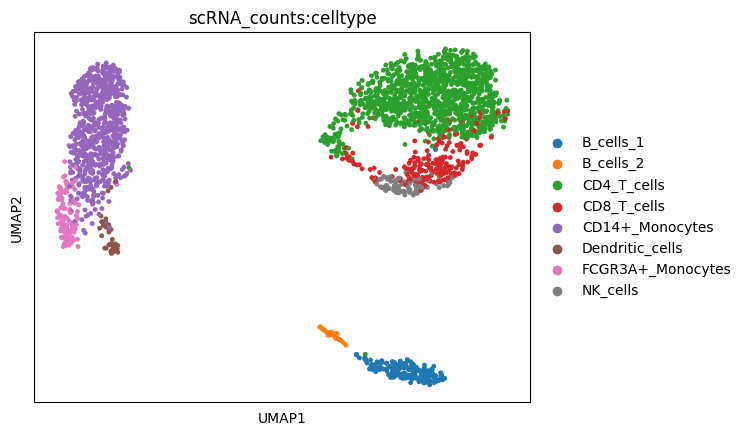

In [27]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")
sc.tl.umap(eRegulon_gene_AUC)
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:celltype")

# Converting mudata output to old-style SCENIC+ object.

Not all functions in the original release of SCENIC+ have been updated to use the new mudata output of SCENIC+. While these functions are being updated, they have a conversion function that allows us to still use the old functions by converting the mudata object to the old SCENIC+ object.

In [28]:
from scenicplus.scenicplus_class import mudata_to_scenicplus

In [29]:
scplus_obj = mudata_to_scenicplus(
    mdata = scplus_mdata,
    path_to_cistarget_h5 = "outs/ctx_results.hdf5",
    path_to_dem_h5 = "outs/dem_results.hdf5"
)

In [30]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 2466 x 21255 and n_cells x n_regions = 2466 x 191502
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ingest_celltype_label', 'leiden_res_0.8', 'celltype', 'sample_id'
	menr:'cistarget_DARs_cell_type_B_cells', 'cistarget_DARs_cell_type_B_cells_1', 'cistarget_DARs_cell_type_B_cells_2', 'cistarget_DARs_cell_type_CD14+_Monocytes', 'cistarget_DARs_cell_type_CD4_T_cells', 'cistarget_DARs_cell_type_CD8_T_cells', 'cistarget_DARs_cell_type_FCGR3A+_Monocytes', 'cistarget_DARs_cell_type_NK_cells', 'cistarget_Topics_otsu_Topic1', 'cistarget_Topics_otsu_Topic10', 'cistarget_Topics_otsu_

In [31]:
from scenicplus.scenicplus_mudata import ScenicPlusMuData

## eRegulon specificity score

In [32]:
from scenicplus.RSS import *

In [33]:
regulon_specificity_scores

<function scenicplus.RSS.regulon_specificity_scores(scplus_mudata: Union[mudata._core.mudata.MuData, scenicplus.scenicplus_mudata.ScenicPlusMuData], variable: str, modalities: list, selected_regulons: List[int] = None)>

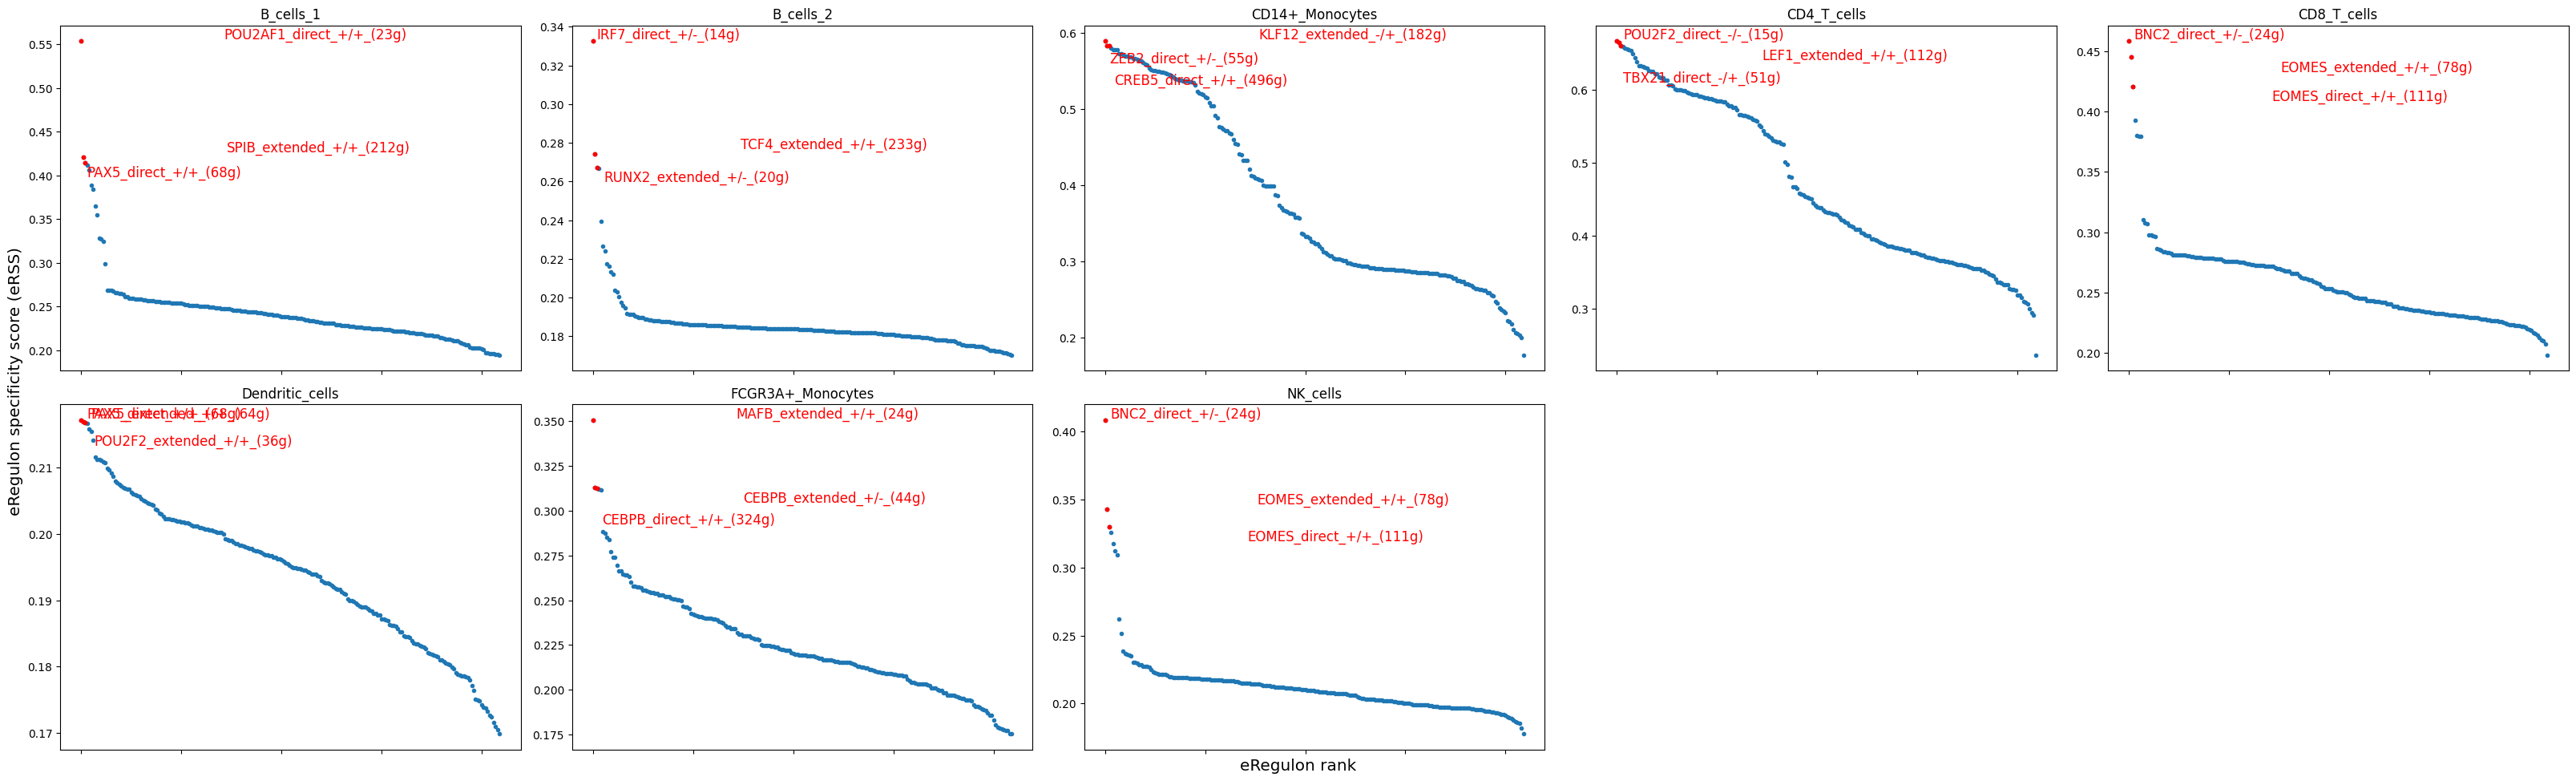

In [34]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:celltype",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

In [35]:
rss

,ARID3A_direct_-/-_(12g),ATF3_direct_+/+_(161g),ATF3_direct_-/-_(95g),BACH1_direct_+/+_(781g),BACH1_direct_-/+_(129g),BACH1_direct_-/-_(278g),BACH2_direct_+/-_(235g),BACH2_direct_-/+_(722g),BACH2_direct_-/-_(276g),BCL11A_direct_+/-_(186g),...,SPIB_extended_-/-_(65g),TBX21_extended_+/+_(152g),TCF12_extended_-/+_(18g),TCF4_extended_+/+_(233g),TCF4_extended_-/-_(22g),TCF7L2_extended_+/-_(135g),TCF7L2_extended_-/+_(27g),TCF7_extended_+/+_(112g),TCF7_extended_-/-_(84g),TCFL5_extended_+/-_(11g)
NK_cells,0.211046,0.196564,0.214528,0.196344,0.223079,0.221332,0.207413,0.209744,0.216007,0.202221,...,0.216932,0.325955,0.227227,0.210850,0.207021,0.203319,0.215191,0.199948,0.207771,0.197522
CD14+_Monocytes,0.247012,0.580439,0.293502,0.569294,0.283771,0.289409,0.297575,0.537045,0.515946,0.407167,...,0.399903,0.290555,0.311966,0.367439,0.330170,0.514450,0.264306,0.290311,0.535706,0.281196
B_cells_1,0.237521,0.217088,0.257417,0.224769,0.247137,0.253152,0.263819,0.217944,0.221263,0.354953,...,0.202509,0.212144,0.253703,0.327500,0.194494,0.228618,0.253728,0.224689,0.243096,0.226294
CD8_T_cells,0.250736,0.230020,0.274364,0.226910,0.286658,0.281283,0.262256,0.248586,0.258725,0.238801,...,0.270205,0.392471,0.269108,0.250202,0.278510,0.238631,0.275774,0.253491,0.243233,0.207923
CD4_T_cells,0.525774,0.355054,0.585120,0.371681,0.586804,0.583459,0.599381,0.379838,0.389546,0.418647,...,0.537821,0.441421,0.528441,0.431277,0.605809,0.403130,0.626553,0.655005,0.362428,0.315849
FCGR3A+_Monocytes,0.203380,0.246801,0.219109,0.246377,0.216919,0.217445,0.211250,0.253807,0.251387,0.224057,...,0.220939,0.207961,0.224934,0.216671,0.209714,0.264380,0.198119,0.194183,0.251940,0.196570
B_cells_2,0.179136,0.180944,0.184192,0.182357,0.183944,0.185221,0.184063,0.185006,0.185523,0.217467,...,0.174643,0.179701,0.194448,0.274060,0.173423,0.178898,0.178467,0.178033,0.186976,0.174843
Dendritic_cells,0.186221,0.201760,0.196438,0.197451,0.194809,0.195249,0.192780,0.202292,0.202641,0.200179,...,0.188949,0.184615,0.197345,0.198285,0.181910,0.197218,0.184486,0.180310,0.203770,0.181825


## Plot eRegulon enrichment scores

eRegulon enrichment scores can be plotted on the UMAP.

/Users/merve/opt/anaconda3/envs/scenicplus/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


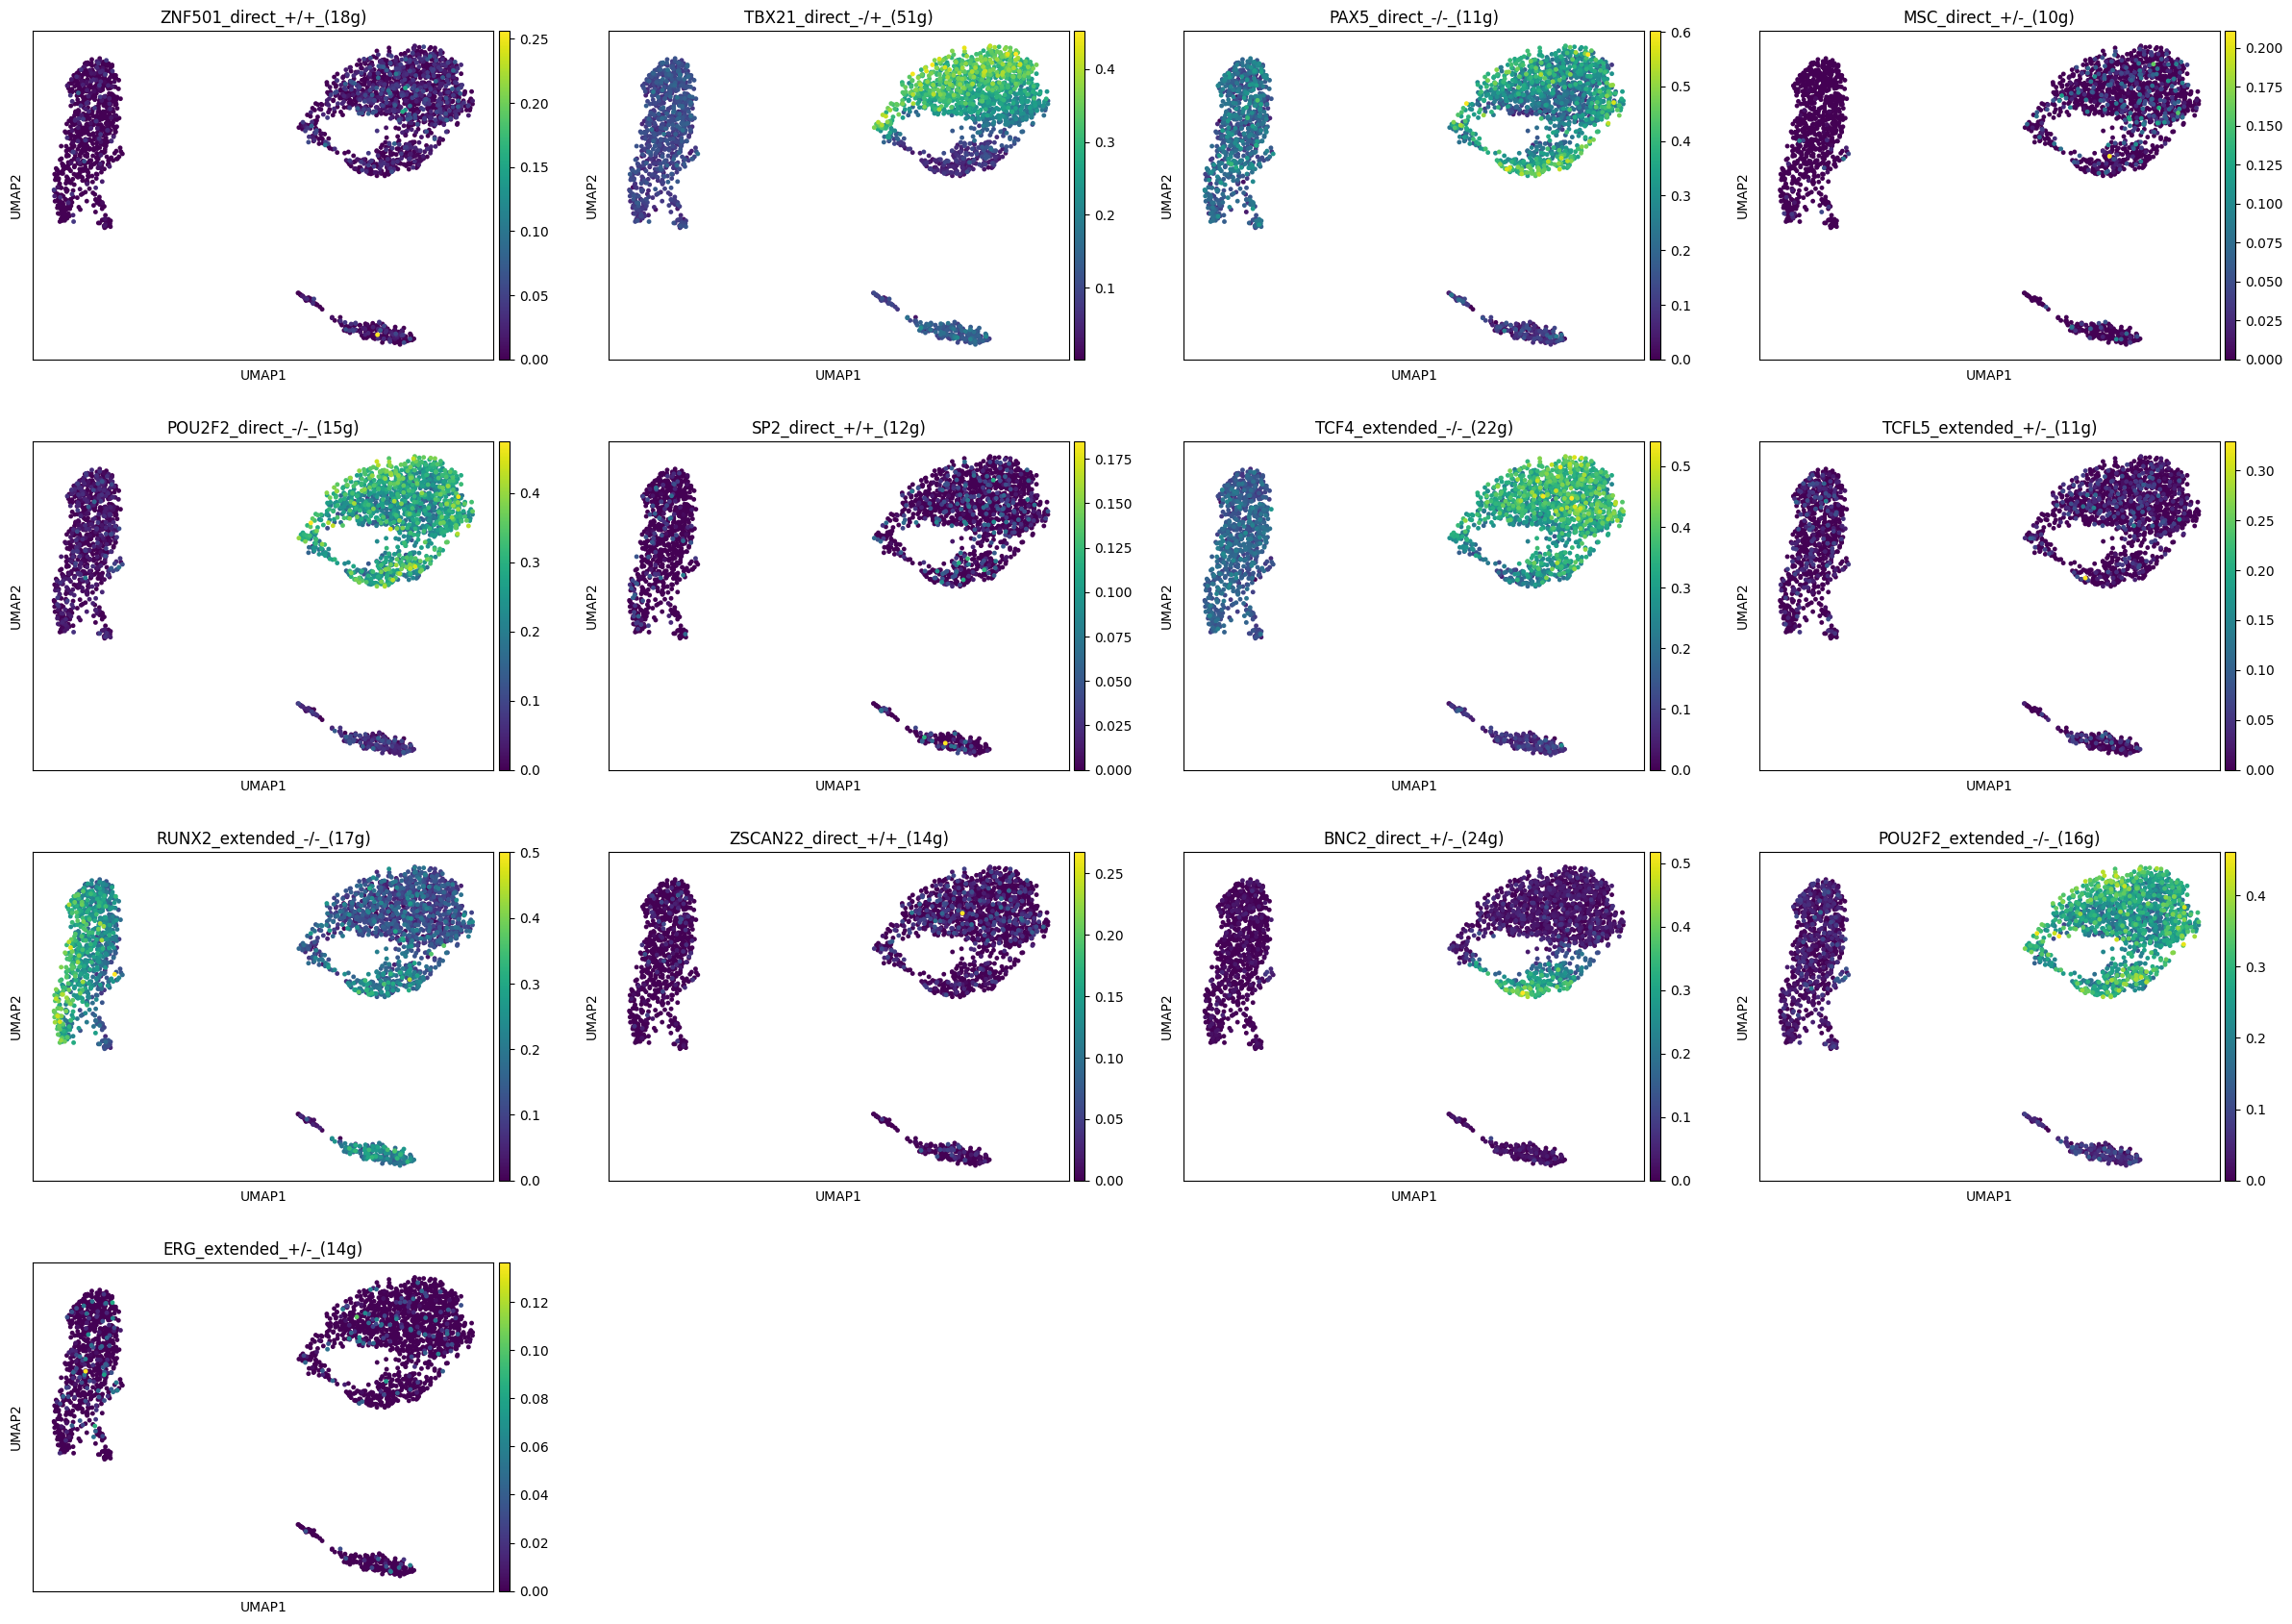

In [36]:
#from scenicplus.RSS import *
sc.pl.umap(eRegulon_gene_AUC, 
           color = list(set([x for xs in [rss.loc[ct].sort_values()[0:2].index for ct in rss.index] for x in xs ])))

In [37]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, aes, scale_fill_distiller, 
    geom_tile, theme, element_text, element_blank)
from plotnine.facets import facet_grid
import plotnine
from typing import List, Union, Optional, Tuple
from mudata import MuData

In [38]:
def _scale(X: pd.DataFrame) -> pd.DataFrame:
    return (X - X.min()) / (X.max() - X.min())

In [39]:
def generate_dotplot_df(
    size_matrix: pd.DataFrame,
    color_matrix: pd.DataFrame,
    group_by: List[str],
    size_features: List[str], # size_features, color_features and feature_names the order should correspond, e.g. color_features, size_features, feature_names = scplus_mudata.uns["direct_e_regulon_metadata"][["Region_signature_name", "Gene_signature_name", "eRegulon_name"]].drop_duplicates().values.T
    color_features: List[str],
    feature_names: List[str],
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_name: str = "group",
    size_name: str = "size_variable",
    color_name: str = "color_variable",
    feature_name: str = "eRegulon") -> pd.DataFrame:
    # Validate input
    if not all(size_matrix.index == color_matrix.index):
        raise ValueError("Both size_matrix and color_matrix should have the same index")
    if len(group_by) != len(size_matrix.index):
        raise ValueError("Length of group_by does not match with the index")
    if len(size_features) != len(color_features) != len(feature_names):
        raise ValueError("The length of 'size_features', 'color_features' and 'feature_names' should be equal!")
    # Subset and order for features
    size_matrix = size_matrix[size_features]
    color_matrix = color_matrix[color_features]
    # Calculate mean by group_by variable
    color_matrix_avg = color_matrix.groupby(group_by).mean()
    size_matrix_avg = size_matrix.groupby(group_by).mean()
    # Scale matrices
    color_matrix_avg = _scale(color_matrix_avg) if scale_color_matrix else color_matrix_avg
    size_matrix_avg = _scale(size_matrix_avg) if scale_size_matrix else size_matrix_avg
    # Transform dataframe into long format
    color_matrix_avg = color_matrix_avg.stack().reset_index()
    size_matrix_avg = size_matrix_avg.stack().reset_index()
    color_matrix_avg.columns = [group_name, "color_features", color_name]
    size_matrix_avg.columns = [group_name, "size_features", size_name]
    # map between color and size feature names to feature names
    color_features_to_name = dict(zip(color_features, feature_names))
    size_features_to_name = dict(zip(size_features, feature_names))
    # Add feature names to dataframe
    color_matrix_avg[feature_name] = [
        color_features_to_name[f] for f in color_matrix_avg["color_features"]]
    size_matrix_avg[feature_name] = [
        size_features_to_name[f] for f in size_matrix_avg["size_features"]]
    color_matrix_avg = color_matrix_avg.drop("color_features", axis = 1)
    size_matrix_avg = size_matrix_avg.drop("size_features", axis = 1)
    dotplot_df = color_matrix_avg.merge(
        size_matrix_avg,
        on = [group_name, feature_name])
    return dotplot_df

In [40]:
def heatmap_dotplot(
    scplus_mudata: Union[MuData, ScenicPlusMuData],
    size_modality: str,
    color_modality: str,
    group_variable: str,
    eRegulon_metadata_key: str,
    size_feature_key: str,
    color_feature_key: str,
    feature_name_key: str,
    sort_data_by: str,
    subset_feature_names: Optional[List[str]] = None,
    scale_size_matrix: bool = True,
    scale_color_matrix: bool = True,
    group_variable_order: Optional[List[str]] = None,
    save: Optional[str] = None,
    figsize: Tuple[float, float] = (5, 8),
    split_repressor_activator: bool = True,
    orientation: str = 'vertical'):
    # Generate dataframe for plotting
    size_matrix = scplus_mudata[size_modality].to_df()
    color_matrix = scplus_mudata[color_modality].to_df()
    group_by = scplus_mudata.obs[group_variable].tolist()
    if subset_feature_names is None:
        size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
            [size_feature_key, color_feature_key, feature_name_key]] \
            .drop_duplicates().values.T
    else:
        size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
            [size_feature_key, color_feature_key, feature_name_key]] \
            .drop_duplicates().query(f"{feature_name_key} in @subset_feature_names").values.T
    plotting_df = generate_dotplot_df(
        size_matrix=size_matrix,
        color_matrix=color_matrix,
        group_by=group_by,
        size_features=size_features,
        color_features=color_features,
        feature_names=feature_names,
        scale_size_matrix=scale_size_matrix,    
        scale_color_matrix=scale_color_matrix,
        group_name=group_variable,
        size_name=size_modality,
        color_name=color_modality,
        feature_name=feature_name_key)
    # Order data
    if group_variable_order is not None:
        if len(set(group_variable_order) & set(plotting_df[group_variable])) != len(set(plotting_df[group_variable])):
            Warning('not all indices are provided in index_order, order will not be changed!')
        else:
            plotting_df[group_variable] = pd.Categorical(plotting_df[group_variable], categories=group_variable_order)
    tmp = plotting_df[[group_variable, feature_name_key, sort_data_by]] \
            .pivot_table(index=group_variable, columns=feature_name_key) \
            .fillna(0)[sort_data_by]
    if group_variable_order is not None:
        tmp = tmp.loc[group_variable_order]
    idx_max = tmp.idxmax(axis = 0)
    order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
    plotting_df[feature_name_key] = pd.Categorical(plotting_df[feature_name_key], categories=order)
    # Plotting
    plotnine.options.figure_size = figsize
    plotting_df["repressor_activator"] = [
            "activator" if "+" in n.split("_")[2] else "repressor" for n in plotting_df[feature_name_key]]
    if split_repressor_activator and len(set(plotting_df["repressor_activator"])) == 2:
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes(group_variable, feature_name_key))
                + facet_grid(
                    'repressor_activator ~ .', 
                    scales = "free", 
                    space = {'x': [1], 'y': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes(feature_name_key, group_variable))
                + facet_grid(
                    '. ~ repressor_activator', 
                    scales = "free", 
                    space = {'y': [1], 'x': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_text_x=element_text(rotation=90, hjust=1))
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    else:
        if orientation == 'vertical':
            plot = (
                ggplot(plotting_df, aes(group_variable, feature_name_key))
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
        elif orientation == 'horizontal':
            plot = (
                ggplot(plotting_df, aes(feature_name_key, group_variable))
                + geom_tile(mapping = aes(fill = color_modality))
                + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
                + geom_point(
                        mapping = aes(size = size_modality),
                        colour = "black")
                + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
    if save is not None:
        plot.save(save)
    else:
        return plot

## Heatmap dotplot

We can draw a heatmap where the color represents target gene enrichment and the dotsize target region enrichment.

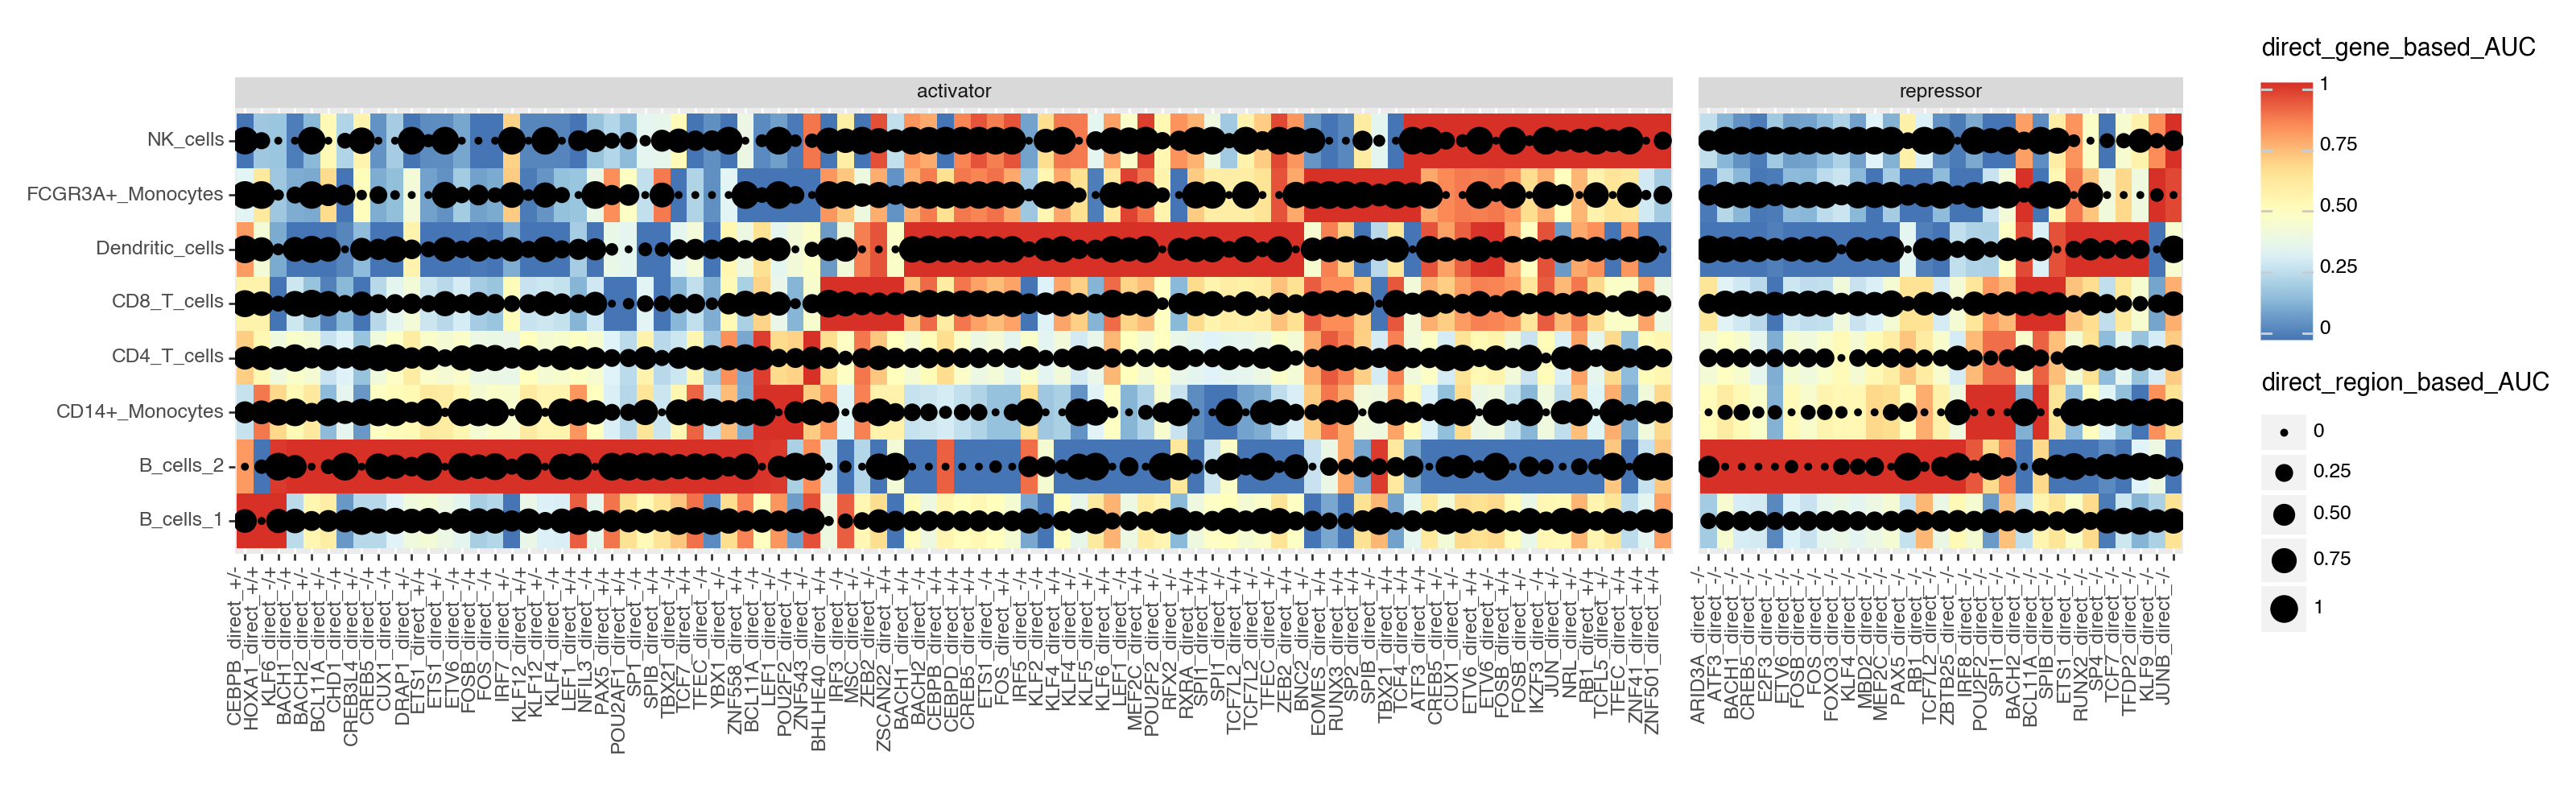

<Figure Size: (1600 x 500)>

In [41]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scRNA_counts:celltype",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)

In [42]:
scplus_mdata
scplus_mdata.write(out_dir+'/scplus_mdata.h5mu')

In [43]:
scenicplus = scplus_mdata['direct_gene_based_AUC'].to_df()
scenicplus

,ARID3A_direct_-/-_(12g),ATF3_direct_+/+_(161g),ATF3_direct_-/-_(95g),BACH1_direct_+/+_(781g),BACH1_direct_-/+_(129g),BACH1_direct_-/-_(278g),BACH2_direct_+/-_(235g),BACH2_direct_-/+_(722g),BACH2_direct_-/-_(276g),BCL11A_direct_+/-_(186g),...,TFEC_direct_-/+_(21g),YBX1_direct_+/-_(64g),ZBTB25_direct_-/-_(12g),ZEB2_direct_+/+_(56g),ZEB2_direct_+/-_(55g),ZNF41_direct_+/+_(10g),ZNF501_direct_+/+_(18g),ZNF543_direct_+/-_(10g),ZNF558_direct_+/+_(11g),ZSCAN22_direct_+/+_(14g)
Cell,,,,,,,,,,,,,,,,,,,,,
AAACAGCCAAATATCC-1-10x_pbmc,0.062245,0.061837,0.326702,0.062909,0.253685,0.251237,0.181650,0.109477,0.113498,0.042110,...,0.303454,0.081550,0.112339,0.143344,0.062311,0.000000,0.000000,0.000000,0.129992,0.00000
AAACAGCCAGGAACTG-1-10x_pbmc,0.000000,0.165394,0.217844,0.169023,0.143145,0.124586,0.128148,0.172887,0.175437,0.063934,...,0.204498,0.134672,0.000000,0.167719,0.095442,0.000000,0.000000,0.000000,0.000000,0.00000
AAACAGCCAGGCTTCG-1-10x_pbmc,0.000000,0.209754,0.076170,0.200296,0.034340,0.056129,0.062725,0.189597,0.170559,0.059565,...,0.000000,0.057532,0.105284,0.239669,0.214915,0.000000,0.000000,0.000000,0.000000,0.00000
AAACCAACACCTGCTC-1-10x_pbmc,0.013562,0.045903,0.319869,0.053073,0.166955,0.186248,0.234003,0.048869,0.042108,0.110172,...,0.296152,0.058531,0.035278,0.053672,0.035030,0.000000,0.000000,0.000000,0.000000,0.00000
AAACCAACAGATTCAT-1-10x_pbmc,0.024537,0.055159,0.301223,0.056306,0.289345,0.266042,0.183255,0.087409,0.099496,0.022117,...,0.346548,0.070776,0.000000,0.063046,0.021500,0.000000,0.000000,0.037065,0.069101,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1-10x_pbmc,0.000000,0.050315,0.277477,0.078578,0.135735,0.163583,0.208326,0.065414,0.066959,0.140857,...,0.216369,0.048712,0.050564,0.098794,0.042042,0.000000,0.026811,0.000000,0.036518,0.00000
TTTGTGGCATTAGCCA-1-10x_pbmc,0.204374,0.044951,0.382799,0.052976,0.219636,0.179203,0.277729,0.046759,0.045837,0.042186,...,0.202303,0.036850,0.179915,0.015556,0.042744,0.000000,0.000000,0.077140,0.000000,0.00000
TTTGTGGCATTGCGAC-1-10x_pbmc,0.101364,0.034790,0.316077,0.053597,0.273280,0.249633,0.185425,0.091444,0.101552,0.041772,...,0.220624,0.173036,0.103089,0.059199,0.052681,0.000000,0.033605,0.000000,0.000000,0.00000


In [44]:
cell_names = scplus_mdata.obs['scRNA_counts:celltype'].tolist()
scenicplus.index=cell_names

In [45]:
scenicplus.columns = [col.split('_')[0] for col in scenicplus.columns]
scenicplus.to_csv(out_dir + '/scenicplus_cell_tf.csv')
scenicplus

,ARID3A,ATF3,ATF3,BACH1,BACH1,BACH1,BACH2,BACH2,BACH2,BCL11A,...,TFEC,YBX1,ZBTB25,ZEB2,ZEB2,ZNF41,ZNF501,ZNF543,ZNF558,ZSCAN22
FCGR3A+_Monocytes,0.062245,0.061837,0.326702,0.062909,0.253685,0.251237,0.181650,0.109477,0.113498,0.042110,...,0.303454,0.081550,0.112339,0.143344,0.062311,0.000000,0.000000,0.000000,0.129992,0.00000
FCGR3A+_Monocytes,0.000000,0.165394,0.217844,0.169023,0.143145,0.124586,0.128148,0.172887,0.175437,0.063934,...,0.204498,0.134672,0.000000,0.167719,0.095442,0.000000,0.000000,0.000000,0.000000,0.00000
CD4_T_cells,0.000000,0.209754,0.076170,0.200296,0.034340,0.056129,0.062725,0.189597,0.170559,0.059565,...,0.000000,0.057532,0.105284,0.239669,0.214915,0.000000,0.000000,0.000000,0.000000,0.00000
CD14+_Monocytes,0.013562,0.045903,0.319869,0.053073,0.166955,0.186248,0.234003,0.048869,0.042108,0.110172,...,0.296152,0.058531,0.035278,0.053672,0.035030,0.000000,0.000000,0.000000,0.000000,0.00000
CD4_T_cells,0.024537,0.055159,0.301223,0.056306,0.289345,0.266042,0.183255,0.087409,0.099496,0.022117,...,0.346548,0.070776,0.000000,0.063046,0.021500,0.000000,0.000000,0.037065,0.069101,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD4_T_cells,0.000000,0.050315,0.277477,0.078578,0.135735,0.163583,0.208326,0.065414,0.066959,0.140857,...,0.216369,0.048712,0.050564,0.098794,0.042042,0.000000,0.026811,0.000000,0.036518,0.00000
CD14+_Monocytes,0.204374,0.044951,0.382799,0.052976,0.219636,0.179203,0.277729,0.046759,0.045837,0.042186,...,0.202303,0.036850,0.179915,0.015556,0.042744,0.000000,0.000000,0.077140,0.000000,0.00000
CD14+_Monocytes,0.101364,0.034790,0.316077,0.053597,0.273280,0.249633,0.185425,0.091444,0.101552,0.041772,...,0.220624,0.173036,0.103089,0.059199,0.052681,0.000000,0.033605,0.000000,0.000000,0.00000
CD4_T_cells,0.021872,0.070286,0.156558,0.068724,0.130689,0.098669,0.149593,0.059166,0.064785,0.052813,...,0.191551,0.043641,0.095406,0.036134,0.060498,0.066604,0.009669,0.000000,0.029761,0.00000
